# Detect and model multimodal regression data sets

Presuppose:
- regression data sets;
- predict a probability density function (PDF) to get (data/model/predictive) uncertainty.

Problems:
1. Detect/determine a multimodal regression data set.
2. Model, i.e. predict targets, a multimodal regression data set.

Solution:
1. Use a probability integral transform (PIT) histogram because calibration curve is not so reliable.
2. Use a mixture density network (MDN): designed for multimodal regression data sets and produces PDFs.

Literature review:
So far the calibration curve has been used to assess calibration.

My comments on the calibration curve:
It was not used to detect multimodal regression data sets.
It produces S-shaped curve for multimodal regression data sets.

Experiments:
UCI regression data sets are commonly used: boston, concrete, kin8nm, naval, power, protein, wine, yacht, year.
Some of them are too small.
However, the *protein* and *year* data sets are clearly multimodal.
I detected it with PIT histograms.
I can achieve SOTA in terms of negative log-likelihood (NLL) with MDNs: see my table with NLL.
With MDNs calibration is much better.

## Protein data set

In [14]:
from matplotlib import pyplot as plt
from matplotlib import gridspec
import numpy as np
from scipy.stats import norm

from ada import *

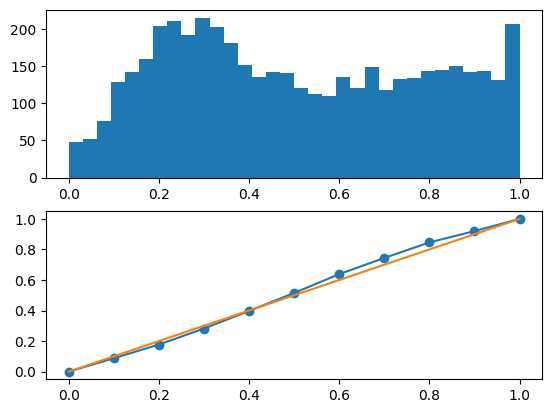

In [8]:
(trainset, testset), (X_scaler, y_scaler) = get_dataset("protein", 50, False, True)
x_test, y_test = testset.tensors
features = x_test.shape[-1]
nn = NeuralNetwork(features, {"hiddens": 1, "k": 1, "neurons": 64, "loss": "nll"})
nn.load("nll-1-1-7968")
y_nn = nn.predict(testset)
_, (ax1, ax2) = plt.subplots(nrows=2)
ax1.hist(normal_pit(*y_nn, y_test).squeeze(), bins=BINS);
calibration_curve(ax2, normal_reliability(*y_nn, y_test))

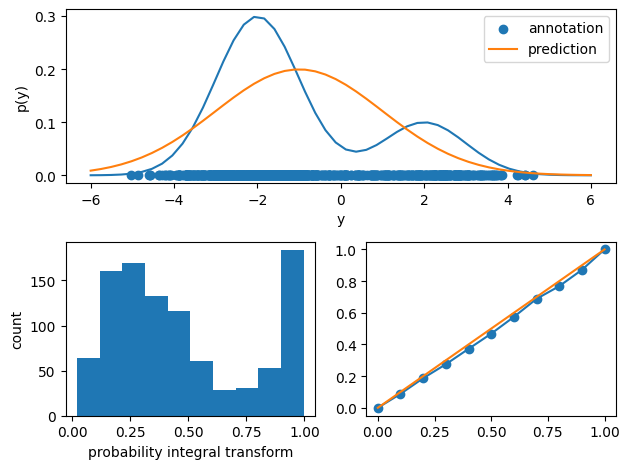

In [17]:
def plot_annotation(ax, x):
    ax.scatter(x, np.zeros_like(x), label="annotation")

def plot_prediction(ax, x, mu, sigma):
    ax.plot(x, norm.pdf(x, mu, sigma), label="prediction")

def pit_histogram(ax, x, mu, sigma):
    ax.hist(norm.cdf(x, loc=mu, scale=sigma))
    ax.set_xlabel("probability integral transform")
    ax.set_ylabel("count")

def reliability_diagram(ax, x, mu, sigma):
    def reliability(confidence):
        a, b = norm.interval(confidence, loc=mu, scale=sigma)
        return np.sum((a < x) & (x < b)) / len(x)
    confidences = np.linspace(0.0, 1.0, num=11)
    ax.plot(confidences, list(map(reliability, confidences)), marker="o")
    ax.plot(confidences, confidences)

def plot_multimodal(ax, x, coef, loc, scale):
    ax.plot(x, coef[0] * norm.pdf(x, loc[0], scale[0]) + coef[1] * norm.pdf(x, loc[1], scale[1]))
    ax.set_xlabel("y")
    ax.set_ylabel("p(y)")

def multimodal(mu, sigma, coef=[0.5, 0.5], loc=[-2, 2], scale=[1, 1], n=1000, start=-6, stop=6):
    fig = plt.figure(tight_layout=True)
    gs = gridspec.GridSpec(2, 2)
    ax0 = fig.add_subplot(gs[0, :])
    ax1 = fig.add_subplot(gs[1, 0])
    ax2 = fig.add_subplot(gs[1, 1]) 
    y = np.random.default_rng().normal(loc=loc, scale=scale, size=(n, len(coef)))[np.arange(n), np.random.choice(np.arange(len(coef)), size=n, p=coef)]
    plot_annotation(ax0, y)
    domain = np.linspace(start, stop)
    plot_multimodal(ax0, domain, coef, loc, scale)
    plot_prediction(ax0, domain, mu, sigma)
    ax0.legend()
    pit_histogram(ax1, y, mu, sigma)
    reliability_diagram(ax2, y, mu, sigma)

multimodal(-1, 2, coef=[0.75, 0.25])

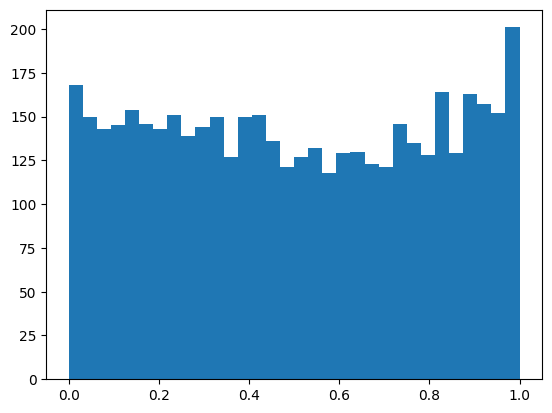

In [20]:
mdn = MixtureDensityNetwork(features, {"hiddens": 2, "k": 5, "neurons": 64, "loss": "nll"})
mdn.load("nll-1-5-2837")
y_mdn = mdn.predict(testset)
plt.hist(gmm_pit(*y_mdn, y_test).squeeze(), bins=BINS);

## Year data set

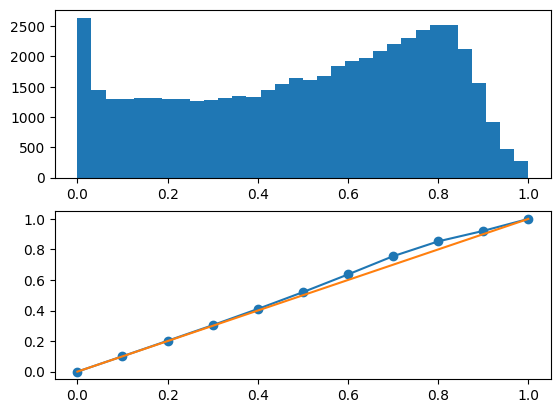

In [23]:
(trainset, testset), (X_scaler, y_scaler) = get_dataset("year", 50, False, True)
x_test, y_test = testset.tensors
features = x_test.shape[-1]
nn = NeuralNetwork(features, {"hiddens": 3, "k": 1, "neurons": 32, "loss": "nll"})
nn.load("nll-1-1-4569")
y_nn = nn.predict(testset)
_, (ax1, ax2) = plt.subplots(nrows=2)
ax1.hist(normal_pit(*y_nn, y_test).squeeze(), bins=BINS);
calibration_curve(ax2, normal_reliability(*y_nn, y_test))

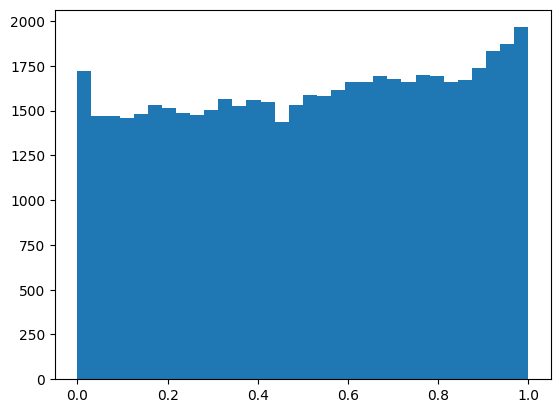

In [24]:
mdn = MixtureDensityNetwork(features, {"hiddens": 5, "k": 5, "neurons": 64, "loss": "nll"})
mdn.load("nll-1-5-3344")
y_mdn = mdn.predict(testset)
plt.hist(gmm_pit(*y_mdn, y_test).squeeze(), bins=BINS);